## INF 385: Lecture 10

active learning and recommendation systems

In [2]:
# hide warnings to keep things tidy.
import warnings
warnings.filterwarnings('ignore')
import operator
import random 

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint
    
import numpy as np 

%pylab inline


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
# this is a spam / ham dataset of SMS messages; 
# credit to https://github.com/amueller/scipy_2015_sklearn_tutorial
import os
with open("SMSSpamCollection.txt") as f:
    lines = [line.strip().split("\t") for line in f.readlines()]
text = [x[1] for x in lines]
y = [x[0] == "ham" for x in lines]

In [4]:
text[:10], y[:10]

(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  'Ok lar... Joking wif u oni...',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
  'U dun say so early hor... U c already then say...',
  "Nah I don't think he goes to usf, he lives around here though",
  "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, $1.50 to rcv",
  'Even my brother is not like to speak with me. They treat me like aids patent.',
  "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
  'WINNER!! As a valued network customer you have been selected to receivea $900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',


In [5]:
text_train, text_test, y_train, y_test = train_test_split(text, y, random_state=42)

In [6]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

In [7]:
X_train.shape

(4180, 7202)

In [8]:
y_train = np.array(y_train)

First use a 'standard' (or 'passive') learning approach, sampling the first 1000 examples (at random)

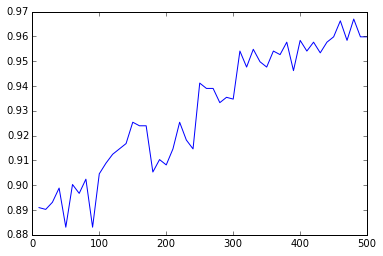

In [9]:
n_labels_total = 500
sampled_thus_far = 10 # we'll initialize with 10
k = 10 # sample 5 examples in each 'batch'
pool = X_train # all available examples (that we could have labeled)
pool_indices = list(range(pool.shape[0])) # all training instances available
cur_train_indices = [] # the indices sampled thus far 
# start with the first 10
cur_train_indices = pool_indices[:10]
# and remove from pool!
pool_indices = pool_indices[10:]

# initial score
clf = SGDClassifier(loss="log")
clf.fit(X_train[cur_train_indices,:], y_train[cur_train_indices])
score = clf.score(X_test, y_test) # how'd we do?

num_labels = [10] # basically the x-axis we'll want for a learning curve
scores = [score] # how well we do


while sampled_thus_far < n_labels_total:
    
    cur_sample = random.choice(pool_indices, size=k, replace=False)
    
    # remove these so we don't sample again! and
    # add to train/pool sample
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)
    
    # fit to currently selected data
    clf.fit(X_train[cur_train_indices,:], y_train[cur_train_indices])
    score = clf.score(X_test, y_test) # how'd we do?
    scores.append(score)
    
    num_labels.append(len(cur_train_indices))
    sampled_thus_far += k


pylab.plot(num_labels, scores);

your turn (class exercise)! now swap in an 'active learning' method -- uncertainty sampling -- in place of random sampling -- how does this do??

Note: if you finish early; try implementing active learning using a different model/approach (e.g., Naive Bayes + uncertainty sampling)


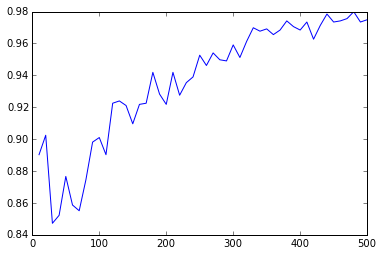

In [10]:
n_labels_total = 500
sampled_thus_far = 10 # we'll initialize with 10
k = 10 # sample 5 examples in each 'batch'
pool = X_train # all available examples (that we could have labeled)
pool_indices = list(range(pool.shape[0])) # all training instances available
cur_train_indices = [] # the indices sampled thus far 
# start with the first 100
cur_train_indices = pool_indices[:10]
# and remove from pool!
pool_indices = pool_indices[10:]

clf = SGDClassifier(loss="log")
# initial score
clf.fit(X_train[cur_train_indices,:], y_train[cur_train_indices])
score = clf.score(X_test, y_test) # how'd we do?

num_labels = [10] # basically the x-axis we'll want for a learning curve
active_scores = [score] # how well we do

while sampled_thus_far < n_labels_total:
    
    ### 
    # here's the block we change!
    # cur_sample = random.choice(pool_indices, size=k, replace=False)
    # predict all probabilities
    indices_to_probs = {}
    for idx in pool_indices:
        indices_to_probs[idx] = abs(0.5 - 
                                    max(clf.predict_proba(X_train[idx])[0]))

                                    
    
    # rank instances!
    sorted_indices = sorted(indices_to_probs, key=indices_to_probs.get)
    # take top k
    cur_sample = sorted_indices[:k]
    ## that's all!
    
    # remove these so we don't sample again! and
    # add to train/pool sample
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)
    
    # fit to currently selected data
    clf.fit(X_train[cur_train_indices,:], y_train[cur_train_indices])
    score = clf.score(X_test, y_test) # how'd we do?
    active_scores.append(score)
    
    num_labels.append(len(cur_train_indices))
    sampled_thus_far += k


pylab.plot(num_labels, active_scores)

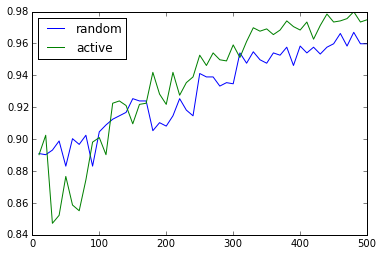

In [11]:
# plot together
pylab.plot(num_labels, scores, label='random')
pylab.plot(num_labels, active_scores, label='active')
pylab.legend(loc="upper left");

### Recommender systems
OK, let's switch gears a bit and experiment with recommender systems.